<a href="https://colab.research.google.com/github/JulianAlex/Exercises_ML_for_Agriculture/blob/main/Solution_Ex_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solution of Exercise 7 

uses www.tensorflow.org/tutorials/images/segmentation as a basis, 
the U-Net is self-implementated.   

Julian Adolphs, 2020


In [1]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

     |████████████████████████████████| 3.8MB 20.7MB/s 


In [2]:
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import MaxPooling2D, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate 
from tensorflow.keras.utils import plot_model

In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [156]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [157]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [158]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [159]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [160]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [161]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [162]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

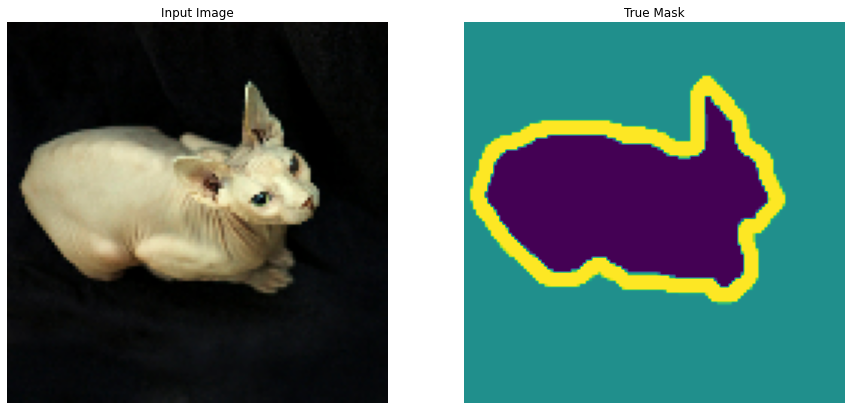

In [163]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [164]:
# Define model with the functional API
layer_0 = Input(shape=(128, 128, 3))
# begin downsampling
conv_1 = Conv2D(filters=64, kernel_size=3, padding='same', activation ='relu')(layer_0) 
conv_1 = Conv2D(filters=64, kernel_size=3, padding='same', activation ='relu')(conv_1)  # 128*128
pool_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)  # 64*64

conv_2 = Conv2D(filters=128, kernel_size=3, padding='same', activation ='relu')(pool_1)  # 64*64
conv_2 = Conv2D(filters=128, kernel_size=3, padding='same', activation ='relu')(conv_2)
pool_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)  # 32*32

conv_3 = Conv2D(filters=256, kernel_size=3, padding='same', activation ='relu')(pool_2)   # 32*32
conv_3 = Conv2D(filters=256, kernel_size=3, padding='same', activation ='relu')(conv_3)
pool_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)  # 16*16  

conv_4 = Conv2D(filters=512, kernel_size=3, padding='same', activation ='relu')(pool_3)   # 16*16
conv_4 = Conv2D(filters=512, kernel_size=3, padding='same', activation ='relu')(conv_4)
pool_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)  # 8*8

conv_5 = Conv2D(filters=1024, kernel_size=3, padding='same', activation ='relu')(pool_4)   # 8*8
conv_5 = Conv2D(filters=1024, kernel_size=3, padding='same', activation ='relu')(conv_5)
pool_5 = MaxPooling2D(pool_size=(2, 2))(conv_5)  # 4*4

conv_6 = Conv2D(filters=2048, kernel_size=3, padding='same', activation ='relu')(pool_5)   # 4*4
conv_6 = Conv2D(filters=1024, kernel_size=3, padding='same', activation ='relu')(conv_6)

# end down-sampling 
#-------------------------------------------------------------------------------
# begin up-sampling: 
upsamp_5 = Conv2DTranspose(1024, kernel_size=3, padding='same', strides=(2,2), activation ='relu')(conv_6)  # 8*8
merge_5  = concatenate([conv_5, upsamp_5]) # 2048 filters
upconv_5 = Conv2D(filters=1024, kernel_size=3, padding='same', activation ='relu')(merge_5)  # 16*16
upconv_5 = Conv2D(filters=512, kernel_size=3, padding='same', activation ='relu')(upconv_5)

upsamp_4 = Conv2DTranspose(512, kernel_size=3, padding='same', strides=(2,2), activation ='relu')(conv_5)  # 16*16
merge_4  = concatenate([conv_4, upsamp_4]) # 1024 filters
upconv_4 = Conv2D(filters=512, kernel_size=3, padding='same', activation ='relu')(merge_4)  # 16*16
upconv_4 = Conv2D(filters=256, kernel_size=3, padding='same', activation ='relu')(upconv_4)

upsamp_3 = Conv2DTranspose(256, kernel_size=3, padding='same', strides=(2,2), activation ='relu')(upconv_4)  
merge_3  = concatenate([conv_3, upsamp_3]) # 512 filters
upconv_3 = Conv2D(filters=256, kernel_size=3, padding='same', activation ='relu')(merge_3)  # 32*32
upconv_3 = Conv2D(filters=128, kernel_size=3, padding='same', activation ='relu')(upconv_3)

upsamp_2 = Conv2DTranspose(64, kernel_size=3, padding='same', strides=(2,2), activation ='relu')(upconv_3)  
merge_2  = concatenate([conv_2, upsamp_2]) # 256 filters 
upconv_2 = Conv2D(filters=128, kernel_size=3, padding='same', activation ='relu')(merge_2)  # 64*46
upconv_2 = Conv2D(filters=64, kernel_size=3, padding='same', activation ='relu')(upconv_2)

upsamp_1 = Conv2DTranspose(64, kernel_size=3, padding='same', strides=(2,2), activation ='relu')(upconv_2)
merge_1  = concatenate([conv_1, upsamp_1]) # 128 filters
upconv_1 = Conv2D(filters=64, kernel_size=3, padding='same', activation ='relu')(merge_1) 
upconv_1 = Conv2D(filters=64, kernel_size=3, padding='same', activation ='relu')(upconv_1)  # 128*128
layer_out = Conv2D(filters=3, kernel_size=1, padding='same', activation ='relu')(upconv_1)  

model = Model(inputs = layer_0, outputs = layer_out) 

model.summary()


Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_214 (Conv2D)             (None, 128, 128, 64) 1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_215 (Conv2D)             (None, 128, 128, 64) 36928       conv2d_214[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_46 (MaxPooling2D) (None, 64, 64, 64)   0           conv2d_215[0][0]                 
___________________________________________________________________________________________

In [165]:
#model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])
LR_START = 0.001 
'''
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = LR_START,
    decay_steps = 3600,
    decay_rate = 0.95)
'''
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = LR_START),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

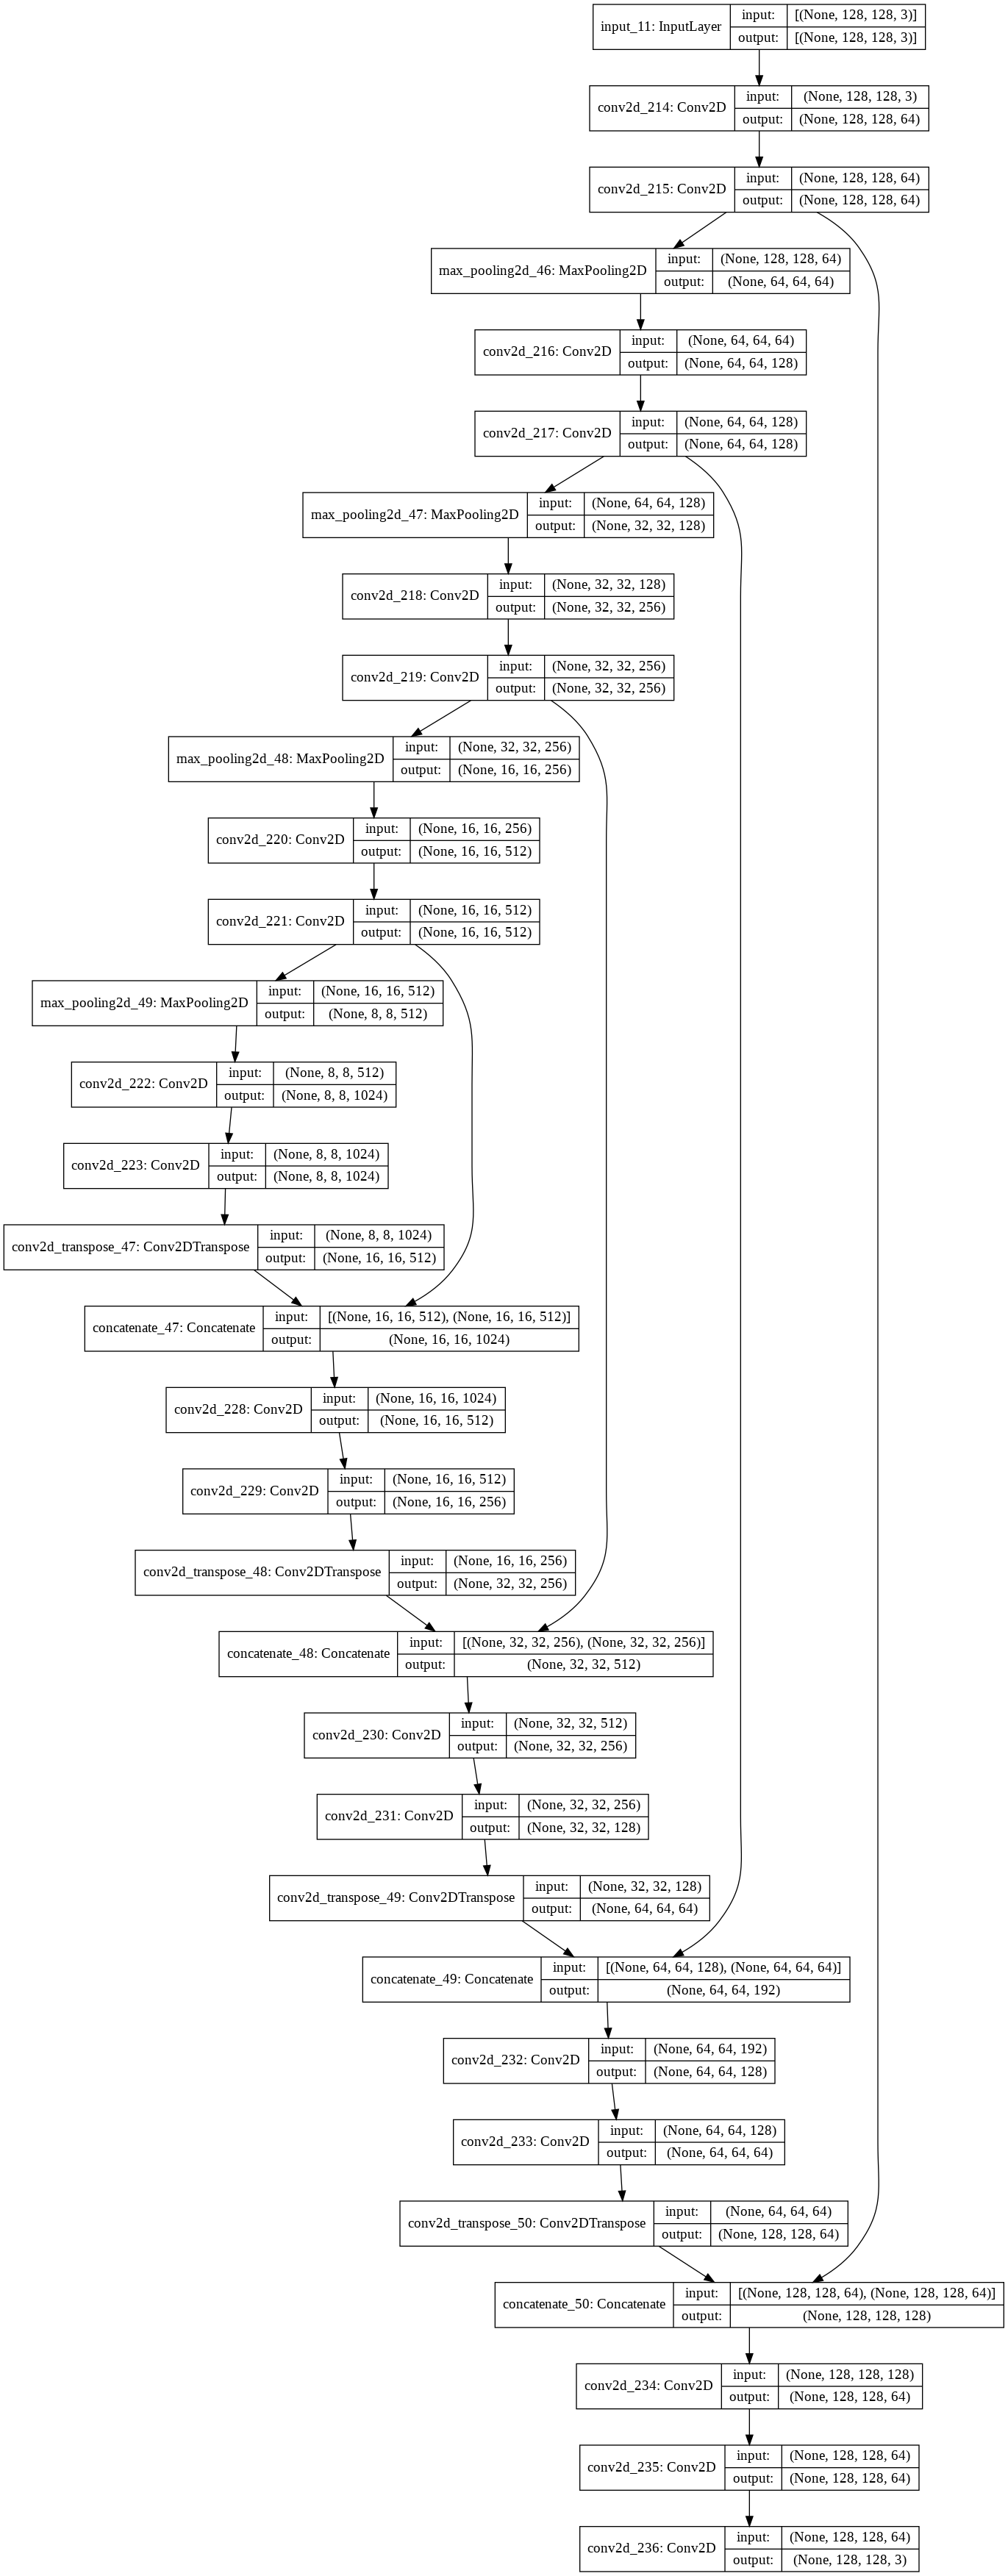

In [166]:
plot_model(model, show_shapes=True)

In [167]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [168]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

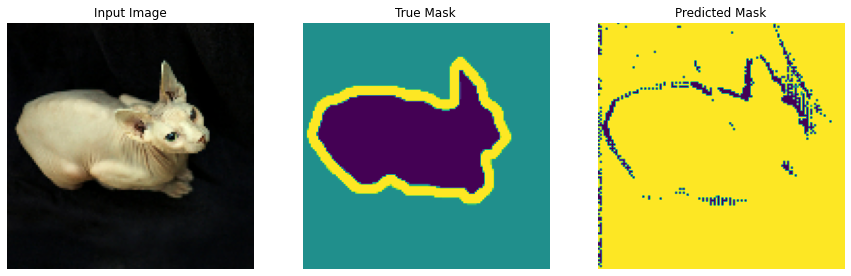

In [169]:
show_predictions()

In [170]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

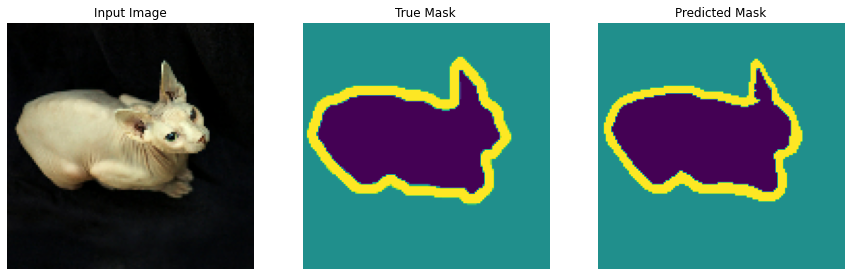


Sample Prediction after epoch 15



In [171]:
EPOCHS = 15
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

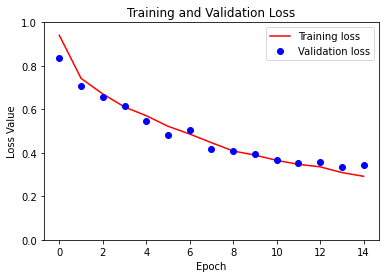

In [172]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

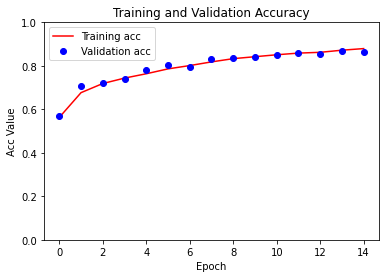

In [173]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'bo', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Acc Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

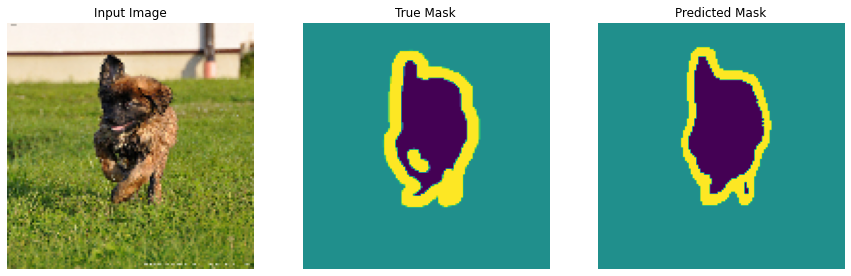

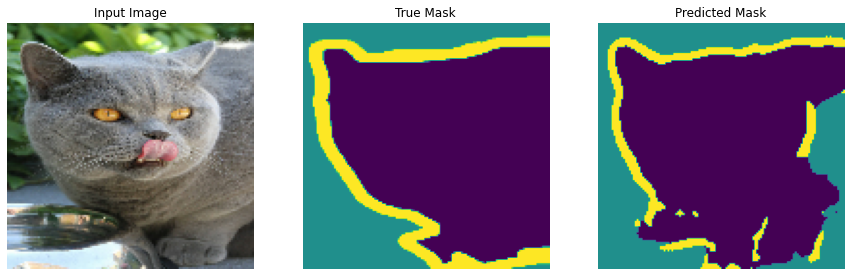

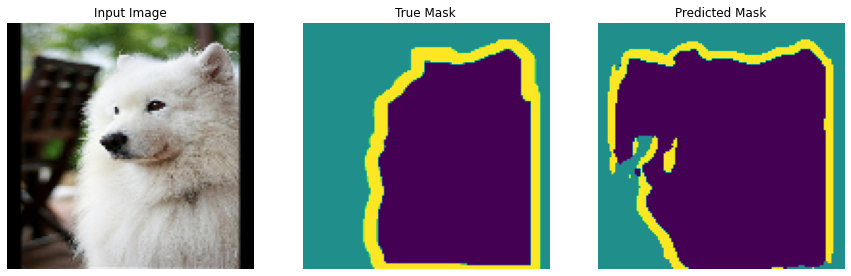

In [174]:
show_predictions(test_dataset, 3)

In [ ]:
info.features